<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Planet-Kaggle-competition" data-toc-modified-id="Planet-Kaggle-competition-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Planet Kaggle competition</a></span><ul class="toc-item"><li><span><a href="#Train" data-toc-modified-id="Train-0.1.1"><span class="toc-item-num">0.1.1&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-0.1.2"><span class="toc-item-num">0.1.2&nbsp;&nbsp;</span>Evaluate</a></span></li><li><span><a href="#End" data-toc-modified-id="End-0.1.3"><span class="toc-item-num">0.1.3&nbsp;&nbsp;</span>End</a></span></li></ul></li></ul></li></ul></div>

- leaky relu / elu

## Planet Kaggle competition

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
#from fast_gen import *
#from learner import *
#from pt_models import *
#from dataset_pt import *
#from sgdr_pt import *

from planet import get_data_pad #*

bs=64; f_model = resnet34 
metrics = [f2]
path = "/data/planet/"
#path = "/data/jhoward/fast/planet/"
#torch.cuda.set_device(1)

In [5]:
n=len(list(open(f'{path}train_v2.csv')))-1 ; n

40479

In [6]:
data=get_data_pad(f_model, path, 256, 64, n, 0)

In [8]:
from fastai.conv_learner import ConvLearner

In [9]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics) #Learner.pretrained_convnet(f_model, data, metrics=[f2])

### Train

In [10]:
learn.fit(0.2, 1, cycle_len=1)

epoch      trn_loss   val_loss   f2                          
    0      0.135461   0.114731   0.903535  



[0.11473080833120947, 0.9035345728533242]

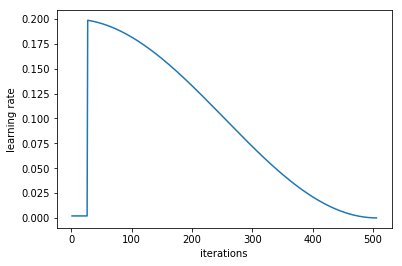

In [11]:
learn.sched.plot_lr()

In [12]:
learn.unfreeze()

In [13]:
learn.fit([0.01,0.05,0.2], 12, cycle_len=4)

epoch      trn_loss   val_loss   f2                          
    0      0.111083   0.096159   0.918099  
    1      0.09847    0.088878   0.925544                     
    2      0.097345   0.086001   0.928081                     
    3      0.090807   0.085407   0.929285                     
    4      0.097966   0.09192    0.923953                     
    5      0.093673   0.085629   0.927882                     
    6      0.08942    0.083518   0.931164                     
    7      0.08618    0.083342   0.931201                     
    8      0.094254   0.08678    0.927089                     
    9      0.090588   0.084871   0.929416                     
    10     0.086462   0.083904   0.930244                     
    11     0.084028   0.083786   0.930673                     
    12     0.09073    0.088978   0.926297                     
    13     0.08558    0.085006   0.930376                     
    14     0.08332    0.083401   0.930652                     
    15     0

[0.09182784397332222, 0.9266973573834828]

In [14]:
learn.fit([1e-4,1e-3,0.01], 4)

epoch      trn_loss   val_loss   f2                           
    0      0.060552   0.091583   0.926517  
    1      0.060993   0.092604   0.926585                     
    2      0.061433   0.09284    0.926211                     
    3      0.062053   0.092234   0.92667                      



[0.09223399638227654, 0.9266702803820709]

### Evaluate

In [15]:
name = '170809'

In [16]:
def load_cycle_cv(cv, cycle):
    data=get_data_zoom(f_model, path, 256, 64, n, cv)
    learn.set_data(data)
    learn.load_cycle(f'{name}_{cv}', cycle)
    return data

In [17]:
data = load_cycle_cv(0,1)

FileNotFoundError: [Errno 2] No such file or directory: '/data/planet/models/170809_0_cyc_1.h5'

In [ ]:
val = learn.predict()

In [ ]:
f2(val,data.val_y)

In [ ]:
f2(learn.TTA(),data.val_y)

In [ ]:
f2(val,data.val_y)

In [ ]:
f2(learn.TTA(),data.val_y)

In [ ]:
def get_labels(a): return [data.classes[o] for o in a.nonzero()[0]]

lbls = test>0.2
idx=9
print(get_labels(lbls[idx]))
PIL.Image.open(path+data.test_dl.dataset.fnames[idx]).convert('RGB')

In [ ]:
res = [get_labels(o) for o in lbls]
data.test_dl.dataset.fnames[:5]

In [ ]:
outp = pd.DataFrame({'image_name': [f[9:-4] for f in data.test_dl.dataset.fnames],
        'tags': [' '.join(l) for l in res]})
outp.head()

In [ ]:
outp.to_csv('tmp/subm.gz', compression='gzip', index=None)

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink('tmp/subm.gz')

In [ ]:
def cycle_preds(name, cycle, n_tta=4, is_test=False):
    learn.load_cycle(name, cycle)
    return learn.TTA(n_tta, is_test=is_test)

def cycle_cv_preds(cv, n_tta=4, is_test=False):
    data=get_data_pad(f_model, path, 256, 64, n, cv)
    learn.set_data(data)
    return [cycle_preds(f'{name}_{cv}',i, is_test=is_test) for i in range(5)]

- check dogs and cats
- get resize working again with new path structure

In [ ]:
%%time
preds_arr=[]
for i in range(5):
    print(i)
    preds_arr.append(cycle_cv_preds(i, is_test=True))

In [ ]:
def all_cycle_cv_preds(end_cycle, start_cycle=0, n_tta=4, is_test=False):
    return [cycle_cv_preds(i, is_test=is_test) for i in range(start_cycle, end_cycle)]

In [ ]:
np.savez_compressed(f'{path}tmp/test_preds', preds_arr)

In [ ]:
preds_avg = [np.mean(o,0) for o in preds_arr]
test = np.mean(preds_avg,0)

In [ ]:
%time preds_arr = all_cycle_cv_preds(5)

In [ ]:
[f2(preds_arr[0][o],data.val_y) for o in range(5)]

In [ ]:
preds_avg = [np.mean(o,0) for o in preds_arr]

In [ ]:
ys = [get_data_zoom(f_model, path, 256, 64, n, cv).val_y for cv in range(5)]

In [ ]:
f2s = [f2(o,y) for o,y in zip(preds_avg,ys)]; f2s

In [ ]:
ots = [opt_th(o,y) for o,y in zip(preds_avg,ys)]; ots

In [ ]:
np.mean(ots)

In [ ]:
np.mean(f2s,0)

### End